# Exploring Energy Balancing Authority Data for Portland

The following explores the EBA data for Portland.  The actual model building occurs in "EBA\_seasonal" and "EBA\_RNN". This file explores correlations, seasonality in the demand data as well as interchange.  Since the data has errors (such as missing values), and occasional spikes we must also check for those anomalies.  The weather data is the NOAA data from the Automated Surface Observation Station at Portland International Airport.

I've made a joint data frame with the weather, and electricity demand.
I've explored some correlations between weather and demand.  I've also looked at the power spectra of the demand, which shows annual, daily and weekly oscillations.  I've also made some plots looking into the seasonality, and some of the mdethods to remove that. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from util.get_weather_data import convert_isd_to_df, convert_state_isd
from util.EBA_util import avg_extremes, remove_na

%matplotlib inline
%load_ext autoreload
%autoreload 2

pi=np.pi

/home/jonathan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#reads in list of airport codes.
air_df = pd.read_csv('data/air_code_df.gz')

#Just get the weather station data for cities in Oregon.
df_weather=convert_state_isd(air_df,'OR')

#Read all of the weather data in.
#df_weather=pd.read_csv('data/airport_weather.gz',index_col=0,parse_dates=True)


done with Portland International Airport
done with Salem Municipal Airport/McNary Field
done with Mahlon Sweet Field


In [3]:
#load electricity data (after tables been rearranged to use a common time index)
df_eba=pd.read_csv('data/EBA_time.gz',index_col=0,parse_dates=True)
#df_region_eba=pd.read_csv('data/EBA_region_time.gz',index_col=0,parse_dates=True)

In [4]:
#Select temperature for Portland, OR
msk1=np.array(df_weather['city']=='Portland')
msk2=np.array(df_weather['state']=='OR')

df_pdx_weath=df_weather.loc[msk1&msk2]

In [5]:
#get electricity data for Portland General Electric
msk=df_eba.columns.str.contains('Portland')
df_pdx=df_eba.loc[:,msk]


In [52]:
df_eba.shape

(20216, 655)

## Plotting data from ISOs

(What timing are these using?  Local time, with issues are daylight savings?  Or UTC time?  Lets try to plot data from New England, and data from Portland General Electric, or Bonneville Power Administration)


Net generation for New York Independent System Operator (NYIS), Hourly    20938.0
Net generation for Portland General Electric Company (PGE), Hourly         2472.0
dtype: float64


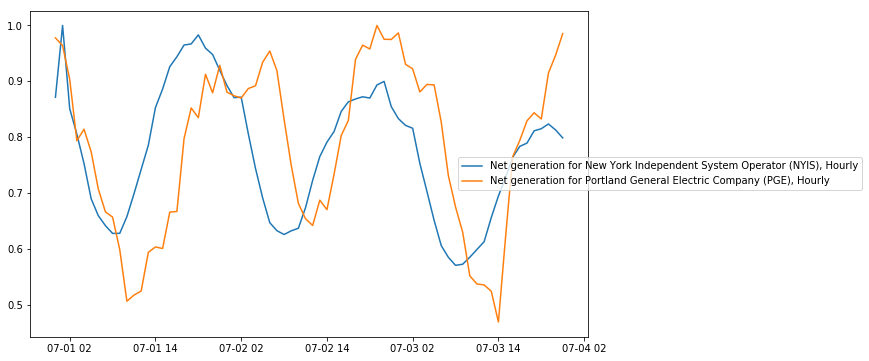

In [6]:
msk1=df_eba.columns.str.contains('Portland')
msk2=df_eba.columns.str.contains('New York')
msk3=df_eba.columns.str.contains('generation')
df_dem=df_eba.loc[:,(msk1|msk2)&msk3]
df_sub=df_dem.iloc[0:72,0:5]  #look at 3 days, first 5 columns
df_max = df_sub.max(axis=0)   #scale all variables to so maximum is 1

print(df_max)
f1=plt.figure(figsize=(10,6))
ax=plt.subplot(111)
for i in range(min(5,len(df_sub.columns))):
    ax.plot(df_sub.iloc[:,i]/df_max[i],label=df_sub.columns[i])
ax.legend(loc='right',bbox_to_anchor=(1.5,0.5))
plt.show()

Evidently, these are using UTC time - the Western time zones results lag those of the eastern timezones by 3 hours. That's a huge relief.

### Anomaly Detection

A quick look at the Portland data suggests that there are both real outliers, and ones from errors in the data process (100x surrounding values).  

Tests should be for total interchange = 0, and Demand=Net Gen - Net Interchange

The following example is for Portland, and shows a huge spike in demand in the middle of the day.  The line shows the corresponding temperature.  Is this real or not?  I suspect it is not real: not excessive temperature, not repeated on following days.
Although earlier data showed the same thing at higher 15min time resolution, with a slower ramp up and down.

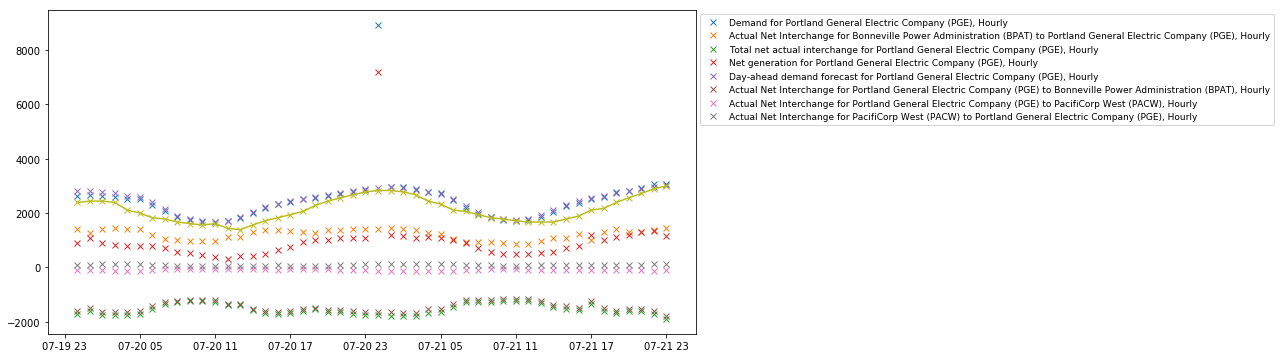

In [7]:
fig=plt.figure(figsize=(15,6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax.plot(df_pdx['2016-07-20':'2016-07-21'],'x')
ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':9})

ax.plot(10*df_pdx_weath['2016-07-20':'2016-07-21']['Temp'],'x-')
#ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':9})

plt.show()

Another set of errors occur for missing values.  There's the section o data from late 2015, when this system was being set up.  A number of these series have this issue.  Otherwise, there are isolated missing occuring at midnight.

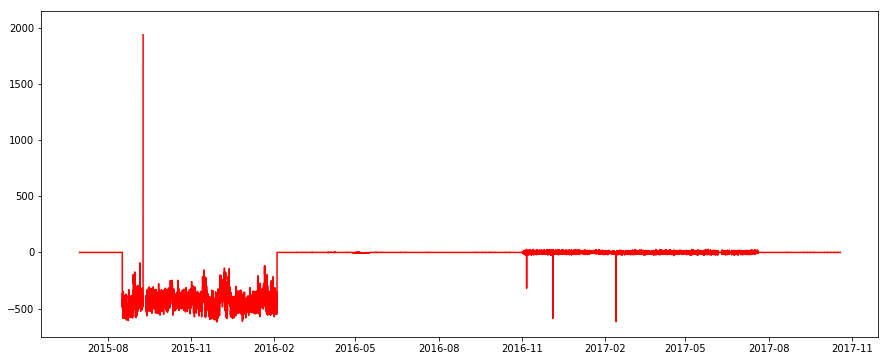

In [8]:
dem=df_pdx.iloc[:,0]
gen=df_pdx.iloc[:,2]
net=df_pdx.iloc[:,3]
fig=plt.figure(figsize=(15,6))
plt.plot(dem-(-gen+net),'r')
plt.show()

The data in later 2015 seem pretty crappy.  Looking at the EBA user notes, this seems to be a common complaint.
The other errors seem to involve some anomalous zero points in the temperature series.  For temperature series where huge swings are unlikely
it may be feasible to replace anomalous 0 values with the average of the neighbouring points.  In case of actual zero values (such as temperature around freezing), this shouldn't be a large problem.

# Removing Extremes

Let's try to clean up some of this data.
My strategy is to find missing (or zero values) or excessive data.  Find values larger than 3x standard deviations from the mean.
Those extreme values are replaced with the mean of the two neighbouring points.
This is also carried out for points with zero. Under the assumption that the data are otherwise continuous, the smoothing should not be a large distortion.

This is done using "remove_na", and "avg_extremes" functions from util.py.


## Correlations between demand and weather

The following makes some scatter plots of the demand for Portland, and the weather information gathered at the airport.
The weather variables track temperature, pressure, precipitation, wind and cloud-cover.

In [9]:
#Make a combined Portland Dataframe for demand vs weather.
dem=df_pdx.iloc[:,0].asfreq('H')
dem=avg_extremes(remove_na(dem))
df_joint=pd.DataFrame(dem)
df_joint=df_joint.join(df_pdx_weath)
df_joint.head()
x=df_joint.iloc[:,0]
y=df_joint.iloc[:,1]
df_joint['TempShift']=150+abs(df_joint['Temp']-150)
df_joint=df_joint.rename(columns={df_joint.columns[0]:'Demand'})
#df_joint.head()

Number of NA values 156
Number of extreme values 1. Number of zero values 3


Text(0.5,1,'Energy Usage vs Temperature in Portland, OR')

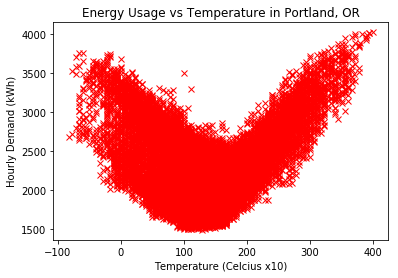

In [10]:
plt.figure()
plt.plot(df_joint['Temp'],df_joint.iloc[:,0],'rx')
plt.ylabel('Hourly Demand (kWh)')
plt.xlabel('Temperature (Celcius x10)')
plt.title('Energy Usage vs Temperature in Portland, OR')

Text(0.5,1,'Energy Usage vs Wind Speed in Portland, OR')

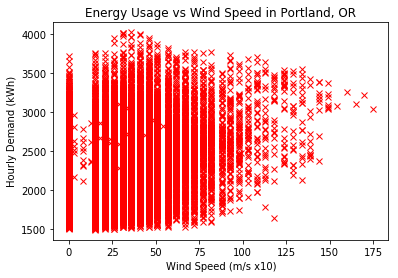

In [11]:
plt.figure()
plt.plot(df_joint['WindSpeed'],df_joint.iloc[:,0],'rx')
plt.xlabel('Wind Speed (m/s x10)')
plt.ylabel('Hourly Demand (kWh)')
plt.title('Energy Usage vs Wind Speed in Portland, OR')

Text(0.5,1,'Energy Usage vs Precipitation in Portland, OR')

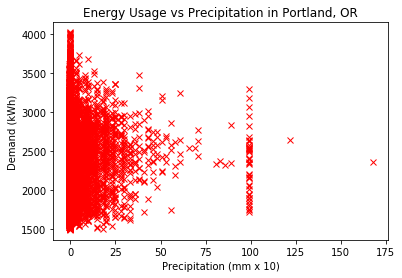

In [12]:
plt.figure()
plt.plot(df_joint['Precip-1hr'],df_joint.iloc[:,0],'rx')
plt.ylabel('Demand (kWh)')
plt.xlabel('Precipitation (mm x 10)')
plt.title('Energy Usage vs Precipitation in Portland, OR')

So the scatterplot for temperature versus demand shows a clear (expected) trend as the temperature becomes excessively hot or cold.
It looks like two blobs with similar slopes for deviations from 15 Celcius.  You can also see anomalous values at zero,
and extremely high values.  I'm skeptical of the 9000kWh value?

Let's also plot the correlation matrix across the whole time series.  Evidently a temperature  deviation from 15 celcius shows the largest correlation, with wind speed being the next most important.
I know the coldest temperatures in some places emerge in inversions (with absolutely no air movement).

In [14]:
pdx_corr=df_joint.corr()

In [15]:
pdx_corr

,Demand,CloudCover,DewTemp,Precip-1hr,Precip-6hr,Pressure,Temp,WindDir,WindSpeed,TempShift
Demand,1.000000,0.001337,-0.141752,0.025889,0.059112,-0.069640,0.088896,0.065773,0.281045,0.644471
CloudCover,0.001337,1.000000,-0.112792,0.149108,0.178737,-0.131804,-0.259230,-0.158562,0.086215,-0.075666
DewTemp,-0.141752,-0.112792,1.000000,0.013433,0.028694,-0.179558,0.738031,0.270941,-0.280002,-0.455269
Precip-1hr,0.025889,0.149108,0.013433,1.000000,0.626609,-0.176323,-0.094895,-0.074599,0.078901,0.014048
Precip-6hr,0.059112,0.178737,0.028694,0.626609,1.000000,-0.307219,-0.088351,-0.044807,0.144958,0.044410
Pressure,-0.069640,-0.131804,-0.179558,-0.176323,-0.307219,1.000000,-0.136697,-0.009541,-0.228290,-0.019447
Temp,0.088896,-0.259230,0.738031,-0.094895,-0.088351,-0.136697,1.000000,0.412033,-0.071634,-0.112946
WindDir,0.065773,-0.158562,0.270941,-0.074599,-0.044807,-0.009541,0.412033,1.000000,0.240277,-0.037280
WindSpeed,0.281045,0.086215,-0.280002,0.078901,0.144958,-0.228290,-0.071634,0.240277,1.000000,0.192363
TempShift,0.644471,-0.075666,-0.455269,0.014048,0.044410,-0.019447,-0.112946,-0.037280,0.192363,1.000000


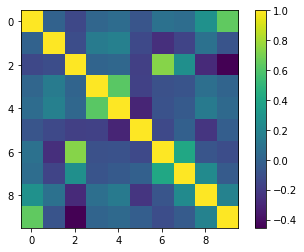

In [16]:
plt.imshow(pdx_corr)
plt.colorbar()
plt.show()

My naive model for how energy usage would vary is a factor for deviation from some ideal temperature, as well as daily and yearly oscillations.
\begin{equation}
    \text{Demand}= A_0+A_T|T-T_0|+A_\text{day}\sin\left( \frac{2\pi t}{24}+\phi_{\text{day}}\right)+A_\text{year}\sin\left(\frac{2\pi d}{365}+\phi_{\text{year}}\right)
\end{equation}
where $t$ is the hour of the day in 24 hour time, and $d$ is the number of days since the start of the year.

To get a sense of those oscillations, let's look at the autocorrelation function for demand, as a function of time.  (Alternatively, the power spectrum?)

# Auto regressive modelling

A popular approach assumes that the current demand is probably the same as the previous demand, with some noise.
This is the auto-regressive, integrated, moving average (ARIMA) class of models that are popular linear models within econometric forecasting.

These models assume that seasonality has been removed from the data, and the residuals are delta-correlated, Gaussian noise.
The following employs some checks looking for seasonality.

The first seasonal decomposition uses a naive method method that estimates the dominant frequency and decomposes the series into an average seasonal pattern within that period, and average change over a given period, and a residual trend.  For the electricity data driven by temperature as well as daily trends from people, this doesn't quite work.

Another tool in determining an ARIMA model is determining the order of the auto-regression (number of past values to track in predicting future), as well as the moving averages (number of past innovations/noises to track in predicting the future).
This can be done by examining the auto-correlation functions (ACF), as well as the partial auto-correlation functions (PACF).  The time the ACF drops below the noise suggests the order for the auto-regression, and the PACF suggests the order for the moving averages 


In [17]:
def make_seasonal_plots(dem,temp,per,nlags):
    """Make seasonal decomposition of temperature, and demand curves.
    Plots those decompositions, and their correlation/autocorrelation plots.
    dem- input demand series
    temp-input temperature series
    per - input date to index on for plotting, e.g. '2016-03'
    nlags - number of lags for correlation plots.
    """
    #Carry out the "demand" and "temperature" seasonal decompositions.
    dem_decomposition = seasonal_decompose(dem,two_sided=False)
    dem_mu=dem.mean()
    dem_trend = dem_decomposition.trend/dem_mu  #Find rolling average over most important period.
    dem_seasonal = dem_decomposition.seasonal/dem_mu  #Find the dominant frequency components
    dem_residual = dem_decomposition.resid/dem_mu  #Whatever is left.

    temp_decomposition = seasonal_decompose(temp,two_sided=False)
    temp_mu=temp.mean()
    temp_trend = temp_decomposition.trend/temp_mu  #Find rolling average over most important period.
    temp_seasonal = temp_decomposition.seasonal/temp_mu  #Find the dominant frequency components
    temp_residual = temp_decomposition.resid/temp_mu  #Whatever is left.

    # numna= lambda x:np.sum(np.isnan(x))
    # print('NA:(trend,seasonal,residual,whole)',numna(temp_trend),numna(temp_seasonal),numna(temp_residual),numna(temp))

    #Plot out the decompositions
    plt.figure(figsize=(15,9))
    plt.title('Normalized Seasonal Decomposition')
    plt.subplot(411)
    plt.plot(dem_trend[per],'b',temp_trend[per],'k')
    plt.ylabel('Trend')
    plt.subplot(412)
    plt.plot(dem_seasonal[per],'b',temp_seasonal[per],'k')
    plt.ylabel('Seasonal Oscillation')
    plt.subplot(413)
    plt.plot(dem_residual[per],'b',temp_residual[per],'k')
    plt.ylabel('Residuals')
    plt.subplot(414)
    plt.plot(dem[per]/dem_mu,'b',temp[per]/temp_mu,'k')
    plt.ylabel('Data')
    plt.show()

    #Plot the auto-correlation plots.
    nlags=np.min([len(dem[per])-1,nlags,len(temp[per])-1])
    print('Nlags',nlags)
    #plt.figure(figsize=(10,6))
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_acf(temp_residual[per],'b-x','Temp Residual',ax1,ax2,nl=nlags)
    plot_acf(dem_residual[per],'r-+','Demand Residual',ax1,ax2,nl=nlags)
    plt.legend()
    plt.show()
    #plt.figure(figsize=(10,6))
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_acf(temp[per],'b-x','Temp',ax1,ax2,nl=nlags)
    plot_acf(dem[per],'r-+','Demand',ax1,ax2,nl=nlags)
    plt.legend()
    plt.show()

    return None

def plot_acf(ts,ls,line_label,ax1,ax2,nl=50):
    """plot_acf(ts,ls,line_label,ax1,ax2,nl)
    Plot the auto-correlation plots for a timeseries (ts) up to a given number of lags (nl)
    Give a specific linestyle (ls), and label.
    Inputs:
    ts - time series
    ls - line style to use when plotting
    line_label - label for this times seris
    ax1, ax2 - axes for sub-plots
    nl - number of lags
    """
    #Actually do those auto-corellations, on the series, and its absolute value.
    ts2 = ts[np.isfinite(ts)]
    lag_acf = acf(ts2,nlags=nl)
    lag_pacf=pacf(ts2,nlags=nl,method='ols')
    #5% confidence intervals.
    sd = 1.96/np.sqrt(len(ts2))
    #Make some purty subplots.
    plt.title('Auto Correlation')
    plt.axhline(y=sd,color='gray')
    plt.axhline(y=-sd,color='gray')
    plt.xlabel('Lag')
    ax1.plot(lag_acf,ls,label=line_label)   
    plt.title('Partial Auto Correlation')
    plt.xlabel('Lag')
    plt.axhline(y=sd,color='gray')
    plt.axhline(y=-sd,color='gray')
    ax2.plot(lag_pacf,ls,label=line_label)    
    return None


Number of extreme values 0. Number of zero values 0
Number of NA values 0
Number of extreme values 0. Number of zero values 0
Number of NA values 0
(JBM) Freq is  24
(JBM) Freq is  24


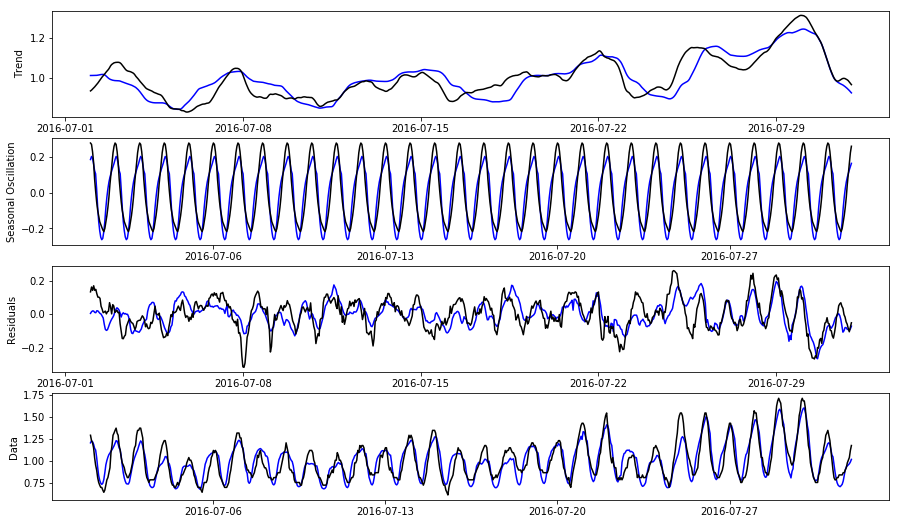

Nlags 50


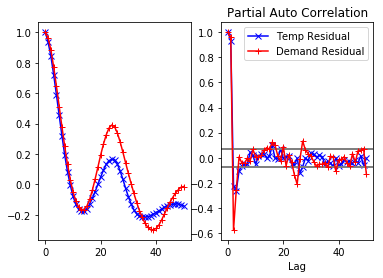

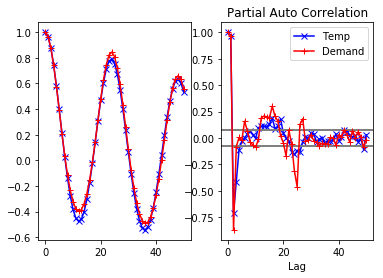

In [18]:
per='2016-07'
dem=df_joint.loc[per,'Demand'].asfreq('H')
dem=avg_extremes(dem)
dem=remove_na(dem)

temp=df_joint.loc[per,'Temp'].asfreq('H')
temp=avg_extremes(temp)
temp=remove_na(temp)

make_seasonal_plots(dem,temp,per,50)

Evidently, this finds the day timescale.  I'm a bit skeptical of these plots, and this approach (trying simple seasonality reduction on the whole data set at once).  I think the seasonal component has not been completely removed.

The autocorrelation plots look at both the temperature and demand for PGE.  The top series is for the residuals, which clearly still show a daily recurrence, while the lower plots are for the raw data. 

The above plot is the raw auto-correlation between the demand and temperature.  I think there is a substantive daily oscillation left by the naive seasonal approach.  This assumes a single oscillation, repeated for all cases.  In this data however, there is a clear daily signal, which it picks out.  However, this will vary over the course of the year.

Diebold's text "Elements of Forecasting" suggests putting in dummy variables for seasonality.  So hour of day, and day of year.
Alternatively, take differences at the dominant frequency.  In this case, we would consider changes from 11am from day to day.

So looking at just an hour of the day, the seasonal split manages to work fairly well at making the residual series a stationary one.
The "trend" is effectively picking out the anticipated annual shifts, and the "seasonality" is pulling out a small week long oscillation (the amplitude is much smaller than the trend).  The residuals also seem to be stationary now.  

The autocorrelation plots also show some oscillations (I think the seasonal reduction is pretty crap), but here they decay to within error after
6 days.  
The raw demand auto-correlations might be showing annual oscillations in temperature and electricity usage that would get stronger from 120-240 days.

If we look at the correlation plots for various hours there are a couple clear trends.  Looking at 6pm, shows a really clear weekly (7 day) signal.  This is not as obvious at other times of day (6am, 9am, 12pm).  Note that I have not selected out weekends, or holidays here.  Weekends might be strongly contributing to the weekly oscillation.  

Number of extreme values 0. Number of zero values 0
Number of NA values 0
Number of extreme values 0. Number of zero values 9
Number of NA values 2
(JBM) Freq is  7
(JBM) Freq is  7


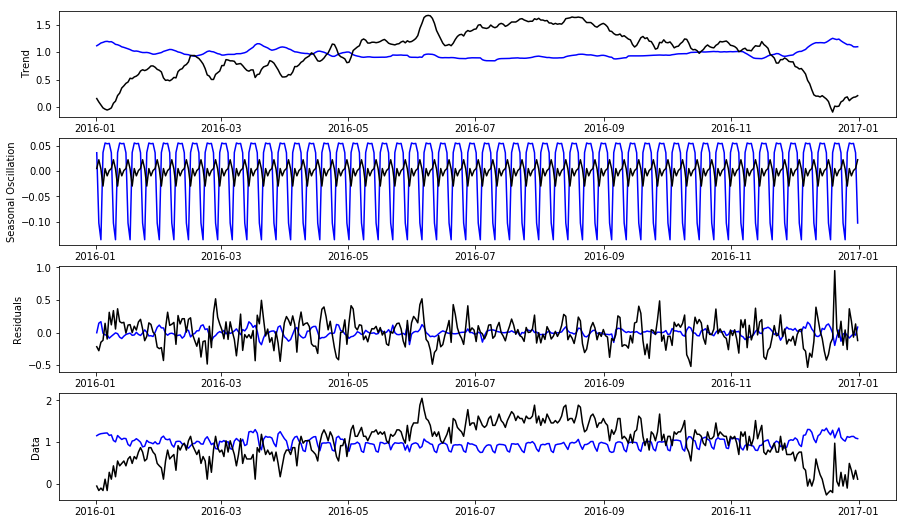

Nlags 40


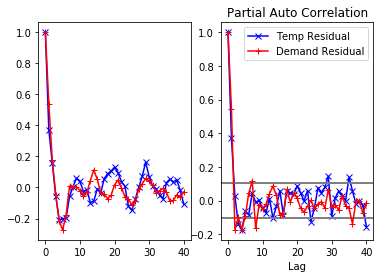

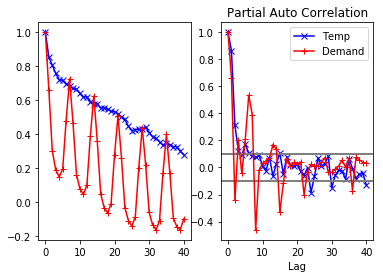

In [19]:
#Compare series at noon
msk=df_joint.index.hour==14

dem=df_joint[msk]['Demand'].asfreq('D')
dem=avg_extremes(dem)
dem=remove_na(dem)

temp=df_joint[msk]['Temp'].asfreq('D')
temp=avg_extremes(temp)
temp=remove_na(temp)
make_seasonal_plots(dem,temp,'2016',40)

So, this seems to show very large amounts of averaging will be required.  There is also a weekly oscillation embedded there (more/less usage on weekends).  In EBA_seasonal, I will try to get around this by using a multi-seasonal exponential smoothing approach, which accounts for both the daily and weekly oscillations. 

## Fourier Plots

I'm curious about the power spectrum for this series.  I'm also unfamiliar with Python's FFT routine, so this is a good time to play around.
I'm going to look at the Fourier spectrum for the demand, over a single year.  I'll then try to filter the data by using removing the peaks at the daily, weekly, and annual timescales. 

In [20]:
#clean up the data
dem_t=df_joint['Demand']['2015-07':'2016-06'].copy()
dem_t=avg_extremes(dem_t)
dem_t=remove_na(dem_t)
dem_tv=dem_t.values

#set up FFT time/frequency scales
Nt = len(dem_tv)
#scale time to days.
Tmax = Nt/24
dt = 1/24
t = np.arange(0,Tmax,dt)
df = 1/Tmax
fmax=0.5/dt
f = np.arange(-fmax,fmax,df)

#carry out fft 
dem_f=np.fft.fftshift(dem_tv)
dem_f=np.fft.fft(dem_f)
dem_f=np.fft.ifftshift(dem_f)

Number of extreme values 0. Number of zero values 0
Number of NA values 0


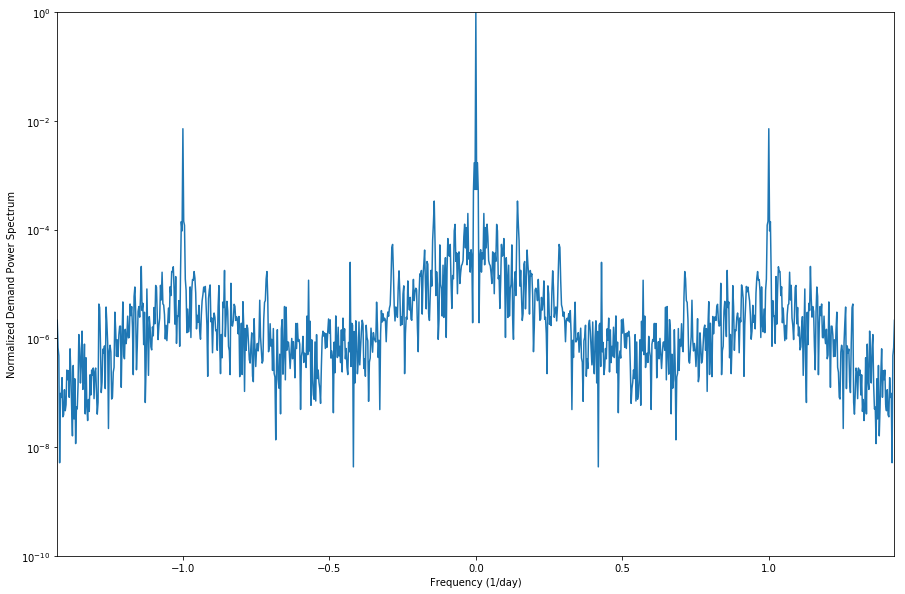

In [21]:
plt.figure(figsize=(15,10))
spec=abs(dem_f)**2
spec/=sum(spec)
plt.semilogy(f,spec)
fcut=1/7
plt.axis([-10*fcut,10*fcut,1E-10,1])
plt.xlabel('Frequency (1/day)')
plt.ylabel('Normalized Demand Power Spectrum')
plt.show()

This is a normalized power spectrum for the demand data.  You can clearly see the peaks arising from daily and weekly oscillations.
There is a small peak at very low frequencies, which corresponds to the annual oscillation.  However, given we only have 2 years of data, this
is almost exactly the Nyquist frequency (lowest frequency that can be resolved).  Let's examine both the high (intra-day) and low (year-long) frequency scales.
The top figure, shows the low frequency (year-long) data.  The lower plot shows nearly the whole frequency spectrum.  Note the peaks at 1,2,3,etc.  These are the daily frequency oscillations.  They also share correlations with other frequencies fo

In [22]:
from EBA_fft import remove_square_peak, remove_sinc_peak, invert_fft, fft_detrend, moving_avg

In [23]:
f_trend_tot,f_detrend = fft_detrend(dem_f,f,4/365,remove_square_peak)
#now take a rolling average of the remainder.
dem_f_s=moving_avg(f_detrend,50)
f_trend_tot+=dem_f_s
f_detrend-=dem_f_s

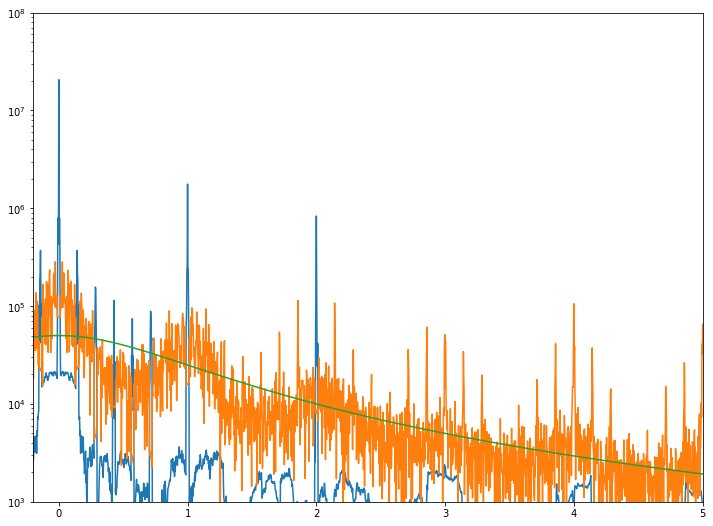

In [25]:
plt.figure(figsize=(12,9))
w=1
plt.axis([-0.2,5,1E3,1E8])
plt.semilogy(f,abs(f_trend_tot),label='Estimated Trend')
plt.semilogy(f,abs(f_detrend),label='Detrended Spectrum')
plt.semilogy(f,5E4/(1+(f/w)**2),label='Estimated Background')
plt.show()

In [26]:
#check out what this detrending looks like.

t_trend=invert_fft(f_trend_tot)
t_detrend=invert_fft(f_detrend)

t_trend=pd.Series(t_trend,index=dem_t.index)
t_detrend=pd.Series(t_detrend,index=dem_t.index)


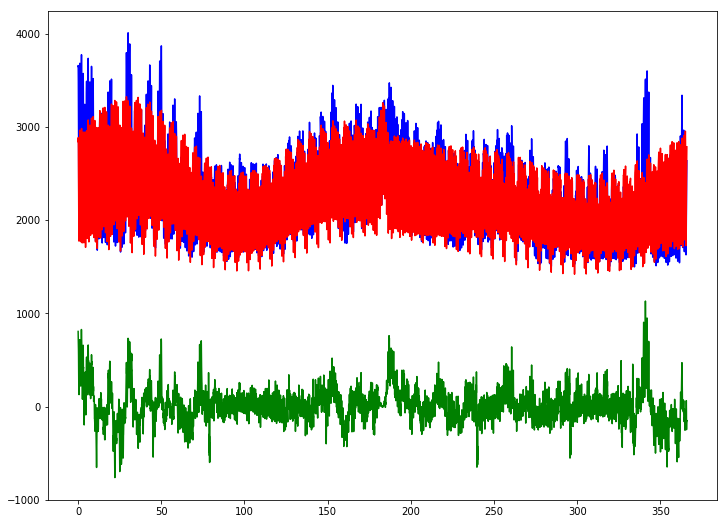

In [27]:
plt.figure(figsize=(12,9))
plt.plot(t,dem_t,'b',t,t_trend,'r',t,t_detrend,'g')
#plt.axis([550,560,min(t_detrend),max(dem_t)])
plt.show()

So that used just July/2015-June/2016 data to find the trend.  Let's now see how this does when applied to the next year's data.
The trend can be appended to itself as a "prediction".  

In [28]:
dem_t2=df_joint['Demand']['2015-07':'2017-06'].copy()
dem_t2=avg_extremes(dem_t2)
dem_t2=remove_na(dem_t2)

#need to ditch a day due to leap year in 2016 elongating the year.
#This might be screwing things up based on day of the week, and leading to a week-long offset
t_trend2 = np.append(t_trend,t_trend[24:])
t_trend2 = pd.Series(t_trend2,index=dem_t2.index)

Number of extreme values 0. Number of zero values 0
Number of NA values 0


In [29]:
t_trend2.tail()

2017-06-30 19:00:00    2553.489615
2017-06-30 20:00:00    2613.699583
2017-06-30 21:00:00    2669.327147
2017-06-30 22:00:00    2726.778275
2017-06-30 23:00:00    2786.448516
Freq: H, dtype: float64

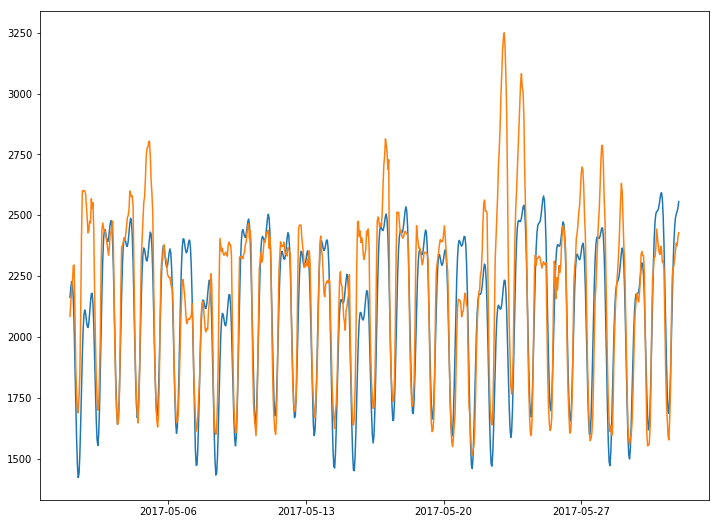

In [30]:
plt.figure(figsize=(12,9))
per='2017-05'
plt.plot(t_trend2[per],label='FFT Trend')
plt.plot(dem_t2[per],label='Actual')
plt.show()

This model just tries finding the average weekly trend, but ignores any temperature data.  So while this has the right order of magnitude, it's a pretty bad forecast.  

## Goals

What is my goal here?  To develop a model for day-ahead electricity forecasts, that optimizes the mean square error.  I have been playing with trying to capture an entire year's data.  (I wanted to explore the seasonal patterns, and try fitting a basic model.)

My goal here was to develop a simple linear model for comparison with neural network approaches.
However, trying to forecast a year's power (at daily resolution) is a fool's errand.  What is a smaller task, I can play with?
I could try fitting day-ahead curves, using the last two week's data.  Each day is then its own problem, with much more manageable requirements.
To finish the ARMA stuff, I can estimate the expected ARMA parameters from a bunch of separate two-week periods. Once the model parameters
are set, I can fit the model for each period, and forecast the next day's behaviour. Those parameters can then be used in the future, perhaps
with feedback based on how they worked in the past.

I also want to fit a Long Short-Term Memory neural network to this data.  This will be done in TensorFlow,  where I will try to build the network using the lower-level instructions, rather than any built-in operations .  This problem seems a good match for this technique, since there are clear correlations, and some scope for nonlinearities.  In this case we must select parameters for the size and depth of
the network.

# Appendices

I've accumulated things I was playing with here, such as the distinction between auto-correlation, and partial auto-correlation plots, and numpy's fft syntax.

## ACF vs PACF

The following example helped me understand the distinction between the ACF and PACF.  The PACF tries to remove the correlation due to the intermediate variables, to find how the innovation/noise a step $k$ in the past, affects the present.   The following model models a random walk, and adds on a delayed copy of itself.  You can see the peaks in the PACF at lags corresponding to the enforced lag.  So the ACF tells us the order of the auto-regression, and PACF tells us the order of the moving average.  

In [114]:
Nx=10000
s=2
x = np.arange(0,Nx)
z= np.random.randn(Nx)
z1=np.zeros(Nx)

z1[s:Nx] = z[0:Nx-s]
y = 2*x +2*z - .5*z1

tindex = pd.date_range('2015-01-01',periods=Nx)
ts = pd.Series(y,index=tindex)
plt.figure()
plot_acf(ts,'r-+','T0',nl=10)
plt.show()